In [1]:
import gc
import os
import sys
import warnings
from glob import glob
import matplotlib.pyplot as plt

import albumentations as A
from albumentations.pytorch import ToTensorV2
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp
from torch.cuda import amp
from tqdm import tqdm

In [2]:
sys.path.append('../')
from script.metrics import *
from script.dataset import *
from script.helper import *
from script.scheduler import *
from script.loss import *

### Config

In [3]:
class CFG:
    debug = False
    # ============== comp exp name =============
    comp_name = 'contrail'
    comp_dir_path = '/kaggle/input/'
    comp_folder_name = 'google-research-identify-contrails-reduce-global-warming'

    dataset_path = "/kaggle/working/dataset_train/ash_color/"

    exp_name = os.getcwd().split('/')[-1]

    # ============== model cfg =============
    model_arch = 'Unet'
    backbone = 'timm-resnest26d'
    in_chans = 3
    target_size = 1

    # ============== training cfg =============
    train_batch_size = 32
    valid_batch_size = train_batch_size

    epochs = 90
    epochs_patience = 12

    lr = 1e-4
    loss = "DiceLoss"

    # ============== fixed =============
    num_workers = 4
    seed = 42

    # ============== augmentation =============
    train_aug_list = [
        A.Resize(384, 384),
        A.RandomRotate90(),
        A.RandomBrightnessContrast(),
        A.ShiftScaleRotate(p=0.5,rotate_limit=(10,10)),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=10, max_width=int(256 * 0.05), max_height=int(256 * 0.05),
                        mask_fill_value=0, p=0.5),
        A.RandomGridShuffle(),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        ToTensorV2(transpose_mask=True),
    ]


warnings.filterwarnings("ignore")
torch.backends.cudnn.benchmark = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
set_seed(CFG.seed)
os.makedirs(f'./{CFG.exp_name}/', exist_ok=True)

# Dataset

In [4]:
train_df = pd.read_csv(f"{CFG.dataset_path}/train_df.csv")
valid_df = pd.read_csv(f"{CFG.dataset_path}/validation_df.csv")

if CFG.debug:
    train_df=train_df[:2000]
    valid_df=valid_df[:2000]
train_df.shape, valid_df.shape

((20529, 2), (1856, 2))


len(dataset_train) = 20529
train_image_shape : torch.Size([3, 384, 384])
train_mask_shape  : torch.Size([1, 384, 384])
train_image_dtype : torch.float32
train_mask_dtype : torch.float32

len(dataset_valid) = 1856
valid_image_shape : torch.Size([3, 256, 256])
valid_mask_shape  : torch.Size([1, 256, 256])
valid_image_dtype : torch.float32
valid_mask_dtype : torch.float32



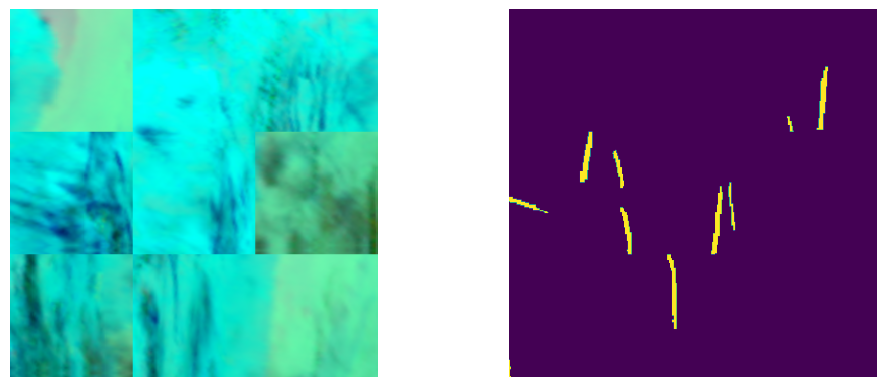

In [5]:
dataset_train = ContrailsDataset(train_df, CFG.train_aug_list)
dataset_valid = ContrailsDataset(valid_df, CFG.valid_aug_list)

dataloader_train = DataLoader(dataset_train, batch_size=CFG.train_batch_size , shuffle=True, num_workers = CFG.num_workers)
dataloader_valid = DataLoader(dataset_valid, batch_size=CFG.valid_batch_size, num_workers = CFG.num_workers)

print(f"""
{len(dataset_train) = }
train_image_shape : {dataset_train[0][0].shape}
train_mask_shape  : {dataset_train[0][1].shape}
train_image_dtype : {dataset_train[0][0].dtype}
train_mask_dtype : {dataset_train[0][1].dtype}

{len(dataset_valid) = }
valid_image_shape : {dataset_valid[0][0].shape}
valid_mask_shape  : {dataset_valid[0][1].shape}
valid_image_dtype : {dataset_valid[0][0].dtype}
valid_mask_dtype : {dataset_valid[0][1].dtype}
""")

show_dataset(112, dataset_train)

# Model

In [6]:
class CustomModel(nn.Module):
    def __init__(self,model_arch, backbone, in_chans, target_size, weight):
        super().__init__()

        self.model = smp.create_model(
            model_arch,
            encoder_name=backbone,
            encoder_weights=weight,
            in_channels=in_chans,
            classes=target_size,
            activation=None,
        )
        
    def forward(self, image):
        output = self.model(image)
        return output


def build_model(model_arch, backbone, in_chans, target_size, weight="imagenet"):
    print('model_arch: ', model_arch)
    print('backbone: ', backbone)
    model = CustomModel(model_arch, backbone, in_chans, target_size, weight)
    return model


num_gpus = torch.cuda.device_count()
device_ids = list(range(num_gpus))

model = build_model(CFG.model_arch, CFG.backbone, CFG.in_chans, CFG.target_size)
model = nn.DataParallel(model, device_ids=device_ids)
model.to(device);

model_arch:  Unet
backbone:  timm-resnest26d


In [7]:
scaler = amp.GradScaler()
criterion = get_lossfn(CFG)
optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

thresholds_to_test = [round(x * 0.01, 2) for x in range(1, 101, 2)]

# Training

In [8]:
if CFG.debug:
    print("!!!Debug mode!!!\n")

dice_score=0
for epoch in range(CFG.epochs):
    model.train()
    
    pbar_train = enumerate(dataloader_train)
    pbar_train = tqdm(pbar_train, total=len(dataloader_train), bar_format="{l_bar}{bar:10}{r_bar}{bar:-0b}")
    loss_train, loss_val= 0.0, 0.0
    for i, (images, masks) in pbar_train:
        images, masks = images.cuda(), masks.cuda()
        optimizer.zero_grad()
        with amp.autocast():
            preds = model(images)
            loss = criterion(preds, masks)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            loss_train += loss.detach().item()
        
        lr = f"LR : {scheduler.get_last_lr()[0]:.2E}"
        gpu_mem = f"Mem : {torch.cuda.memory_reserved() / 1E9:.3g}GB"
        pbar_train.set_description(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{CFG.epochs}", gpu_mem, lr,
                                                                f"Loss: {loss_train / (i + 1):.4f}"))

    scheduler.step()
    model.eval()
    
    cum_pred = []
    cum_true = []
    pbar_val = enumerate(dataloader_valid)
    pbar_val = tqdm(pbar_val, total=len(dataloader_valid), bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
    for i, (images, masks) in pbar_val:
        images, masks = images.cuda(), masks.cuda()
        with torch.no_grad():
            preds = model(images)
            loss_val += criterion(preds, masks).item()
            preds = torch.sigmoid(preds)
            cum_pred.append(preds.cpu().detach().numpy())
            cum_true.append(masks.cpu().detach().numpy())

        pbar_val.set_description(("%10s") % (f"Val Loss: {loss_val / (i+1):.4f}"))
    
    cum_pred = torch.flatten(torch.from_numpy(np.concatenate(cum_pred, axis=0)))
    cum_true = torch.flatten(torch.from_numpy(np.concatenate(cum_true, axis=0)))
    
    dice_score_, thresh = calc_optim_thresh(cum_pred, cum_true, thresholds_to_test)
    
    if dice_score_ > dice_score:
        print(f"FBeta : {dice_score_:.4f}\tthresh : {thresh}\tSAVED MODEL\n")
        dice_score =dice_score_
        torch.save({'model': model.module.state_dict(), 'dice_score': dice_score, 'thresh': thresh,
                    "model_arch":CFG.model_arch, "backbone":CFG.backbone,"in_chans":CFG.in_chans,"target_size":CFG.target_size,},
                    f'./{CFG.exp_name}/{CFG.exp_name}.pth')
    else:
        print(f"FBeta : {dice_score_:.4f}\tthresh : {thresh}\n")
        
!curl -X POST -H 'Authorization: Bearer '$LINE -F 'message=セルの実行が終わりました！{dice_score}' https://notify-api.line.me/api/notify


Epoch 0/90  Mem : 12.4GB  LR : 1.00E-04  Loss: 0.8104: 100%|██████████| 642/642 
Val Loss: 0.6864: 100%|██████████| 58/58 [00:05<00:00, 10.48it/s]               


FBeta : 0.4758	thresh : 0.93	SAVED MODEL



Epoch 1/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.5439: 100%|██████████| 642/642 
Val Loss: 0.5954: 100%|██████████| 58/58 [00:05<00:00, 10.62it/s]               


FBeta : 0.4566	thresh : 0.99



Epoch 2/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.5046: 100%|██████████| 642/642 
Val Loss: 0.5948: 100%|██████████| 58/58 [00:05<00:00, 10.12it/s]               


FBeta : 0.4575	thresh : 0.99



Epoch 3/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.4919: 100%|██████████| 642/642 
Val Loss: 0.5902: 100%|██████████| 58/58 [00:03<00:00, 15.47it/s]               


FBeta : 0.4542	thresh : 0.83



Epoch 4/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.4838: 100%|██████████| 642/642 
Val Loss: 0.5871: 100%|██████████| 58/58 [00:03<00:00, 15.59it/s]               


FBeta : 0.4710	thresh : 0.99



Epoch 5/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.4764: 100%|██████████| 642/642 
Val Loss: 0.5760: 100%|██████████| 58/58 [00:03<00:00, 15.34it/s]               


FBeta : 0.4721	thresh : 0.99



Epoch 6/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.4730: 100%|██████████| 642/642 
Val Loss: 0.5674: 100%|██████████| 58/58 [00:03<00:00, 14.61it/s]               


FBeta : 0.4832	thresh : 0.99	SAVED MODEL



Epoch 7/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.4680: 100%|██████████| 642/642 
Val Loss: 0.5413: 100%|██████████| 58/58 [00:04<00:00, 12.19it/s]               


FBeta : 0.5075	thresh : 0.99	SAVED MODEL



Epoch 8/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.4658: 100%|██████████| 642/642 
Val Loss: 0.5252: 100%|██████████| 58/58 [00:03<00:00, 15.50it/s]               


FBeta : 0.5147	thresh : 0.99	SAVED MODEL



Epoch 9/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.4624: 100%|██████████| 642/642 
Val Loss: 0.5392: 100%|██████████| 58/58 [00:03<00:00, 15.54it/s]               


FBeta : 0.5008	thresh : 0.27



Epoch 10/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.4560: 100%|██████████| 642/642
Val Loss: 0.5535: 100%|██████████| 58/58 [00:03<00:00, 15.59it/s]               


FBeta : 0.5012	thresh : 0.99



Epoch 11/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.4534: 100%|██████████| 642/642
Val Loss: 0.5390: 100%|██████████| 58/58 [00:03<00:00, 15.70it/s]               


FBeta : 0.5099	thresh : 0.99



Epoch 12/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.4530: 100%|██████████| 642/642
Val Loss: 0.5489: 100%|██████████| 58/58 [00:03<00:00, 15.20it/s]               


FBeta : 0.5003	thresh : 0.99



Epoch 13/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.4510: 100%|██████████| 642/642
Val Loss: 0.5157: 100%|██████████| 58/58 [00:03<00:00, 15.81it/s]               


FBeta : 0.5237	thresh : 0.99	SAVED MODEL



Epoch 14/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.4504: 100%|██████████| 642/642
Val Loss: 0.5189: 100%|██████████| 58/58 [00:03<00:00, 15.89it/s]               


FBeta : 0.5343	thresh : 0.99	SAVED MODEL



Epoch 15/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.4447: 100%|██████████| 642/642
Val Loss: 0.4984: 100%|██████████| 58/58 [00:03<00:00, 15.88it/s]               


FBeta : 0.5415	thresh : 0.99	SAVED MODEL



Epoch 16/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.4442: 100%|██████████| 642/642
Val Loss: 0.5214: 100%|██████████| 58/58 [00:03<00:00, 15.59it/s]               


FBeta : 0.5202	thresh : 0.99



Epoch 17/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.4456: 100%|██████████| 642/642
Val Loss: 0.6361: 100%|██████████| 58/58 [00:03<00:00, 15.81it/s]               


FBeta : 0.4066	thresh : 0.99



Epoch 18/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.4415: 100%|██████████| 642/642
Val Loss: 0.5345: 100%|██████████| 58/58 [00:03<00:00, 15.26it/s]               


FBeta : 0.5166	thresh : 0.99



Epoch 19/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.4363: 100%|██████████| 642/642
Val Loss: 0.4887: 100%|██████████| 58/58 [00:03<00:00, 15.40it/s]               


FBeta : 0.5528	thresh : 0.99	SAVED MODEL



Epoch 20/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.4373: 100%|██████████| 642/642
Val Loss: 0.5059: 100%|██████████| 58/58 [00:03<00:00, 15.81it/s]               


FBeta : 0.5361	thresh : 0.99



Epoch 21/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.4390: 100%|██████████| 642/642
Val Loss: 0.5065: 100%|██████████| 58/58 [00:03<00:00, 16.13it/s]               


FBeta : 0.5384	thresh : 0.99



Epoch 22/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.4340: 100%|██████████| 642/642
Val Loss: 0.5256: 100%|██████████| 58/58 [00:03<00:00, 16.10it/s]               


FBeta : 0.5164	thresh : 0.99



Epoch 23/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.4280: 100%|██████████| 642/642
Val Loss: 0.5245: 100%|██████████| 58/58 [00:03<00:00, 16.06it/s]               


FBeta : 0.5216	thresh : 0.99



Epoch 24/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.4294: 100%|██████████| 642/642
Val Loss: 0.5010: 100%|██████████| 58/58 [00:03<00:00, 16.12it/s]               


FBeta : 0.5438	thresh : 0.99



Epoch 25/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.4295: 100%|██████████| 642/642
Val Loss: 0.5322: 100%|██████████| 58/58 [00:03<00:00, 16.08it/s]               


FBeta : 0.5073	thresh : 0.99



Epoch 26/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.4266: 100%|██████████| 642/642
Val Loss: 0.5383: 100%|██████████| 58/58 [00:03<00:00, 15.96it/s]               


FBeta : 0.5001	thresh : 0.99



Epoch 27/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.4224: 100%|██████████| 642/642
Val Loss: 0.5109: 100%|██████████| 58/58 [00:03<00:00, 16.21it/s]               


FBeta : 0.5269	thresh : 0.97



Epoch 28/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.4205: 100%|██████████| 642/642
Val Loss: 0.5073: 100%|██████████| 58/58 [00:03<00:00, 15.80it/s]               


FBeta : 0.5352	thresh : 0.99



Epoch 29/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.4208: 100%|██████████| 642/642
Val Loss: 0.5174: 100%|██████████| 58/58 [00:03<00:00, 16.05it/s]               


FBeta : 0.5230	thresh : 0.99



Epoch 30/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.4195: 100%|██████████| 642/642
Val Loss: 0.4812: 100%|██████████| 58/58 [00:03<00:00, 16.00it/s]               


FBeta : 0.5525	thresh : 0.99



Epoch 31/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.4160: 100%|██████████| 642/642
Val Loss: 0.5046: 100%|██████████| 58/58 [00:03<00:00, 15.75it/s]               


FBeta : 0.5351	thresh : 0.99



Epoch 32/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.4147: 100%|██████████| 642/642
Val Loss: 0.4953: 100%|██████████| 58/58 [00:03<00:00, 15.97it/s]               


FBeta : 0.5498	thresh : 0.99



Epoch 33/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.4136: 100%|██████████| 642/642
Val Loss: 0.5205: 100%|██████████| 58/58 [00:03<00:00, 15.98it/s]               


FBeta : 0.5212	thresh : 0.99



Epoch 34/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.4148: 100%|██████████| 642/642
Val Loss: 0.4779: 100%|██████████| 58/58 [00:03<00:00, 16.00it/s]               


FBeta : 0.5596	thresh : 0.99	SAVED MODEL



Epoch 35/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.4119: 100%|██████████| 642/642
Val Loss: 0.4878: 100%|██████████| 58/58 [00:03<00:00, 15.93it/s]               


FBeta : 0.5538	thresh : 0.99



Epoch 36/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.4114: 100%|██████████| 642/642
Val Loss: 0.4959: 100%|██████████| 58/58 [00:03<00:00, 16.32it/s]               


FBeta : 0.5440	thresh : 0.99



Epoch 37/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.4101: 100%|██████████| 642/642
Val Loss: 0.4723: 100%|██████████| 58/58 [00:03<00:00, 16.12it/s]               


FBeta : 0.5656	thresh : 0.99	SAVED MODEL



Epoch 38/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.4085: 100%|██████████| 642/642
Val Loss: 0.4851: 100%|██████████| 58/58 [00:03<00:00, 15.85it/s]               


FBeta : 0.5538	thresh : 0.99



Epoch 39/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.4073: 100%|██████████| 642/642
Val Loss: 0.4788: 100%|██████████| 58/58 [00:03<00:00, 16.09it/s]               


FBeta : 0.5589	thresh : 0.99



Epoch 40/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.4046: 100%|██████████| 642/642
Val Loss: 0.4748: 100%|██████████| 58/58 [00:03<00:00, 15.93it/s]               


FBeta : 0.5647	thresh : 0.99



Epoch 41/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.4054: 100%|██████████| 642/642
Val Loss: 0.4784: 100%|██████████| 58/58 [00:03<00:00, 16.25it/s]               


FBeta : 0.5594	thresh : 0.99



Epoch 42/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.4027: 100%|██████████| 642/642
Val Loss: 0.4687: 100%|██████████| 58/58 [00:03<00:00, 16.10it/s]               


FBeta : 0.5650	thresh : 0.99



Epoch 43/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.4043: 100%|██████████| 642/642
Val Loss: 0.4667: 100%|██████████| 58/58 [00:03<00:00, 16.10it/s]               


FBeta : 0.5731	thresh : 0.97	SAVED MODEL



Epoch 44/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.3992: 100%|██████████| 642/642
Val Loss: 0.4944: 100%|██████████| 58/58 [00:03<00:00, 15.99it/s]               


FBeta : 0.5486	thresh : 0.99



Epoch 45/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.4011: 100%|██████████| 642/642
Val Loss: 0.5090: 100%|██████████| 58/58 [00:03<00:00, 15.86it/s]               


FBeta : 0.5333	thresh : 0.99



Epoch 46/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.3978: 100%|██████████| 642/642
Val Loss: 0.4565: 100%|██████████| 58/58 [00:03<00:00, 16.06it/s]               


FBeta : 0.5755	thresh : 0.99	SAVED MODEL



Epoch 47/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.3967: 100%|██████████| 642/642
Val Loss: 0.4821: 100%|██████████| 58/58 [00:03<00:00, 15.91it/s]               


FBeta : 0.5568	thresh : 0.99



Epoch 48/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.3951: 100%|██████████| 642/642
Val Loss: 0.4791: 100%|██████████| 58/58 [00:03<00:00, 15.83it/s]               


FBeta : 0.5589	thresh : 0.99



Epoch 49/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.3931: 100%|██████████| 642/642
Val Loss: 0.4788: 100%|██████████| 58/58 [00:03<00:00, 16.00it/s]               


FBeta : 0.5558	thresh : 0.99



Epoch 50/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.3934: 100%|██████████| 642/642
Val Loss: 0.4736: 100%|██████████| 58/58 [00:03<00:00, 16.03it/s]               


FBeta : 0.5604	thresh : 0.99



Epoch 51/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.3915: 100%|██████████| 642/642
Val Loss: 0.4741: 100%|██████████| 58/58 [00:03<00:00, 16.07it/s]               


FBeta : 0.5618	thresh : 0.97



Epoch 52/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.3900: 100%|██████████| 642/642
Val Loss: 0.4635: 100%|██████████| 58/58 [00:03<00:00, 16.01it/s]               


FBeta : 0.5681	thresh : 0.99



Epoch 53/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.3880: 100%|██████████| 642/642
Val Loss: 0.4647: 100%|██████████| 58/58 [00:03<00:00, 16.05it/s]               


FBeta : 0.5721	thresh : 0.99



Epoch 54/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.3905: 100%|██████████| 642/642
Val Loss: 0.4660: 100%|██████████| 58/58 [00:03<00:00, 15.91it/s]               


FBeta : 0.5712	thresh : 0.99



Epoch 55/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.3884: 100%|██████████| 642/642
Val Loss: 0.4639: 100%|██████████| 58/58 [00:03<00:00, 15.92it/s]               


FBeta : 0.5704	thresh : 0.99



Epoch 56/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.3863: 100%|██████████| 642/642
Val Loss: 0.4613: 100%|██████████| 58/58 [00:03<00:00, 15.75it/s]               


FBeta : 0.5718	thresh : 0.99



Epoch 57/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.3864: 100%|██████████| 642/642
Val Loss: 0.4594: 100%|██████████| 58/58 [00:03<00:00, 16.01it/s]               


FBeta : 0.5690	thresh : 0.97



Epoch 58/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.3835: 100%|██████████| 642/642
Val Loss: 0.4541: 100%|██████████| 58/58 [00:03<00:00, 16.23it/s]               


FBeta : 0.5763	thresh : 0.99	SAVED MODEL



Epoch 59/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.3822: 100%|██████████| 642/642
Val Loss: 0.4524: 100%|██████████| 58/58 [00:03<00:00, 15.81it/s]               


FBeta : 0.5811	thresh : 0.99	SAVED MODEL



Epoch 60/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.3816: 100%|██████████| 642/642
Val Loss: 0.4696: 100%|██████████| 58/58 [00:03<00:00, 15.82it/s]               


FBeta : 0.5639	thresh : 0.99



Epoch 61/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.3800: 100%|██████████| 642/642
Val Loss: 0.4596: 100%|██████████| 58/58 [00:03<00:00, 16.10it/s]               


FBeta : 0.5741	thresh : 0.99



Epoch 62/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.3810: 100%|██████████| 642/642
Val Loss: 0.4721: 100%|██████████| 58/58 [00:03<00:00, 16.05it/s]               


FBeta : 0.5601	thresh : 0.73



Epoch 63/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.3770: 100%|██████████| 642/642
Val Loss: 0.4528: 100%|██████████| 58/58 [00:03<00:00, 16.19it/s]               


FBeta : 0.5782	thresh : 0.99



Epoch 64/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.3768: 100%|██████████| 642/642
Val Loss: 0.4467: 100%|██████████| 58/58 [00:03<00:00, 15.96it/s]               


FBeta : 0.5858	thresh : 0.99	SAVED MODEL



Epoch 65/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.3770: 100%|██████████| 642/642
Val Loss: 0.4593: 100%|██████████| 58/58 [00:03<00:00, 15.93it/s]               


FBeta : 0.5745	thresh : 0.99



Epoch 66/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.3751: 100%|██████████| 642/642
Val Loss: 0.4656: 100%|██████████| 58/58 [00:03<00:00, 15.94it/s]               


FBeta : 0.5702	thresh : 0.99



Epoch 67/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.3736: 100%|██████████| 642/642
Val Loss: 0.4508: 100%|██████████| 58/58 [00:03<00:00, 16.09it/s]               


FBeta : 0.5824	thresh : 0.99



Epoch 68/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.3725: 100%|██████████| 642/642
Val Loss: 0.4534: 100%|██████████| 58/58 [00:03<00:00, 16.15it/s]               


FBeta : 0.5793	thresh : 0.97



Epoch 69/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.3713: 100%|██████████| 642/642
Val Loss: 0.4439: 100%|██████████| 58/58 [00:03<00:00, 15.42it/s]               


FBeta : 0.5853	thresh : 0.85



Epoch 70/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.3716: 100%|██████████| 642/642
Val Loss: 0.4519: 100%|██████████| 58/58 [00:03<00:00, 15.66it/s]               


FBeta : 0.5799	thresh : 0.99



Epoch 71/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.3700: 100%|██████████| 642/642
Val Loss: 0.4476: 100%|██████████| 58/58 [00:03<00:00, 15.85it/s]               


FBeta : 0.5840	thresh : 0.99



Epoch 72/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.3700: 100%|██████████| 642/642
Val Loss: 0.4504: 100%|██████████| 58/58 [00:03<00:00, 15.87it/s]               


FBeta : 0.5806	thresh : 0.99



Epoch 73/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.3704: 100%|██████████| 642/642
Val Loss: 0.4475: 100%|██████████| 58/58 [00:03<00:00, 15.99it/s]               


FBeta : 0.5840	thresh : 0.97



Epoch 74/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.3691: 100%|██████████| 642/642
Val Loss: 0.4482: 100%|██████████| 58/58 [00:03<00:00, 15.99it/s]               


FBeta : 0.5829	thresh : 0.95



Epoch 75/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.3676: 100%|██████████| 642/642
Val Loss: 0.4514: 100%|██████████| 58/58 [00:03<00:00, 15.90it/s]               


FBeta : 0.5811	thresh : 0.87



Epoch 76/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.3674: 100%|██████████| 642/642
Val Loss: 0.4475: 100%|██████████| 58/58 [00:03<00:00, 15.98it/s]               


FBeta : 0.5847	thresh : 0.79



Epoch 77/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.3665: 100%|██████████| 642/642
Val Loss: 0.4492: 100%|██████████| 58/58 [00:03<00:00, 15.94it/s]               


FBeta : 0.5813	thresh : 0.99



Epoch 78/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.3659: 100%|██████████| 642/642
Val Loss: 0.4458: 100%|██████████| 58/58 [00:03<00:00, 15.95it/s]               


FBeta : 0.5843	thresh : 0.95



Epoch 79/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.3641: 100%|██████████| 642/642
Val Loss: 0.4483: 100%|██████████| 58/58 [00:03<00:00, 15.95it/s]               


FBeta : 0.5829	thresh : 0.65



Epoch 80/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.3643: 100%|██████████| 642/642
Val Loss: 0.4449: 100%|██████████| 58/58 [00:03<00:00, 15.88it/s]               


FBeta : 0.5864	thresh : 0.99	SAVED MODEL



Epoch 81/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.3673: 100%|██████████| 642/642
Val Loss: 0.4455: 100%|██████████| 58/58 [00:03<00:00, 15.75it/s]               


FBeta : 0.5858	thresh : 0.99



Epoch 82/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.3654: 100%|██████████| 642/642
Val Loss: 0.4451: 100%|██████████| 58/58 [00:03<00:00, 15.80it/s]               


FBeta : 0.5859	thresh : 0.99



Epoch 83/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.3642: 100%|██████████| 642/642
Val Loss: 0.4463: 100%|██████████| 58/58 [00:03<00:00, 15.82it/s]               


FBeta : 0.5855	thresh : 0.87



Epoch 84/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.3647: 100%|██████████| 642/642
Val Loss: 0.4467: 100%|██████████| 58/58 [00:03<00:00, 15.78it/s]               


FBeta : 0.5846	thresh : 0.97



Epoch 85/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.3625: 100%|██████████| 642/642
Val Loss: 0.4478: 100%|██████████| 58/58 [00:03<00:00, 15.68it/s]               


FBeta : 0.5846	thresh : 0.95



Epoch 86/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.3633: 100%|██████████| 642/642
Val Loss: 0.4487: 100%|██████████| 58/58 [00:03<00:00, 16.02it/s]               


FBeta : 0.5835	thresh : 0.97



Epoch 87/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.3629: 100%|██████████| 642/642
Val Loss: 0.4463: 100%|██████████| 58/58 [00:03<00:00, 16.07it/s]               


FBeta : 0.5848	thresh : 0.97



Epoch 88/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.3631: 100%|██████████| 642/642
Val Loss: 0.4474: 100%|██████████| 58/58 [00:03<00:00, 16.00it/s]               


FBeta : 0.5837	thresh : 0.83



Epoch 89/90  Mem : 12.4GB  LR : 1.00E-03  Loss: 0.3655: 100%|██████████| 642/642
Val Loss: 0.4473: 100%|██████████| 58/58 [00:03<00:00, 16.11it/s]               


FBeta : 0.5836	thresh : 0.99

{"status":200,"message":"ok"}

In [9]:
pth = torch.load(f'./{CFG.exp_name}/{CFG.exp_name}.pth')

model = build_model(pth["model_arch"], pth["backbone"], pth["in_chans"], pth["target_size"], weight=None)
model.load_state_dict(pth['model'])
thresh = pth['thresh']
dice_score = pth['dice_score']
print(f"{dice_score:.4f}")

model.to(device)
model.eval();


model_arch:  Unet
backbone:  timm-resnest26d
0.5864


In [10]:
# for i, (images, masks) in enumerate(dataloader_valid):
#     if i!=1: continue
    
#     images, masks = images.cuda(), masks.cuda()
#     with torch.no_grad():
#         preds = model(images)
#         preds = torch.sigmoid(preds)
#     images, masks, preds = images.cpu(), masks.cpu(), preds.cpu()
    
#     for num in range(CFG.valid_batch_size):
#         fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
#         axes = axes.flatten()
#         axes[0].imshow(images[num].permute(1,2,0))
#         axes[0].axis('off')
#         axes[0].set_title('Image')
#         axes[1].imshow(masks[num].permute(1,2,0))
#         axes[1].axis('off')
#         axes[1].set_title('Ground Truth')
#         axes[2].imshow(preds[num].permute(1,2,0))
#         axes[2].axis('off')
#         axes[2].set_title('pred')
#         axes[3].imshow((preds[num]>thresh).permute(1,2,0))
#         axes[3].axis('off')
#         axes[3].set_title('pred_thresh')
#     break